# Python

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [7]:
df = pd.read_csv('data/stock_data.xls')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', errors='coerce')

df = df.dropna()

print(df.dtypes)
print(df.shape)
df.head()

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj_Close           float64
Volume                int64
dtype: object
(4392, 7)


,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000-03-27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000-03-28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000-03-29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000-03-30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000-03-31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


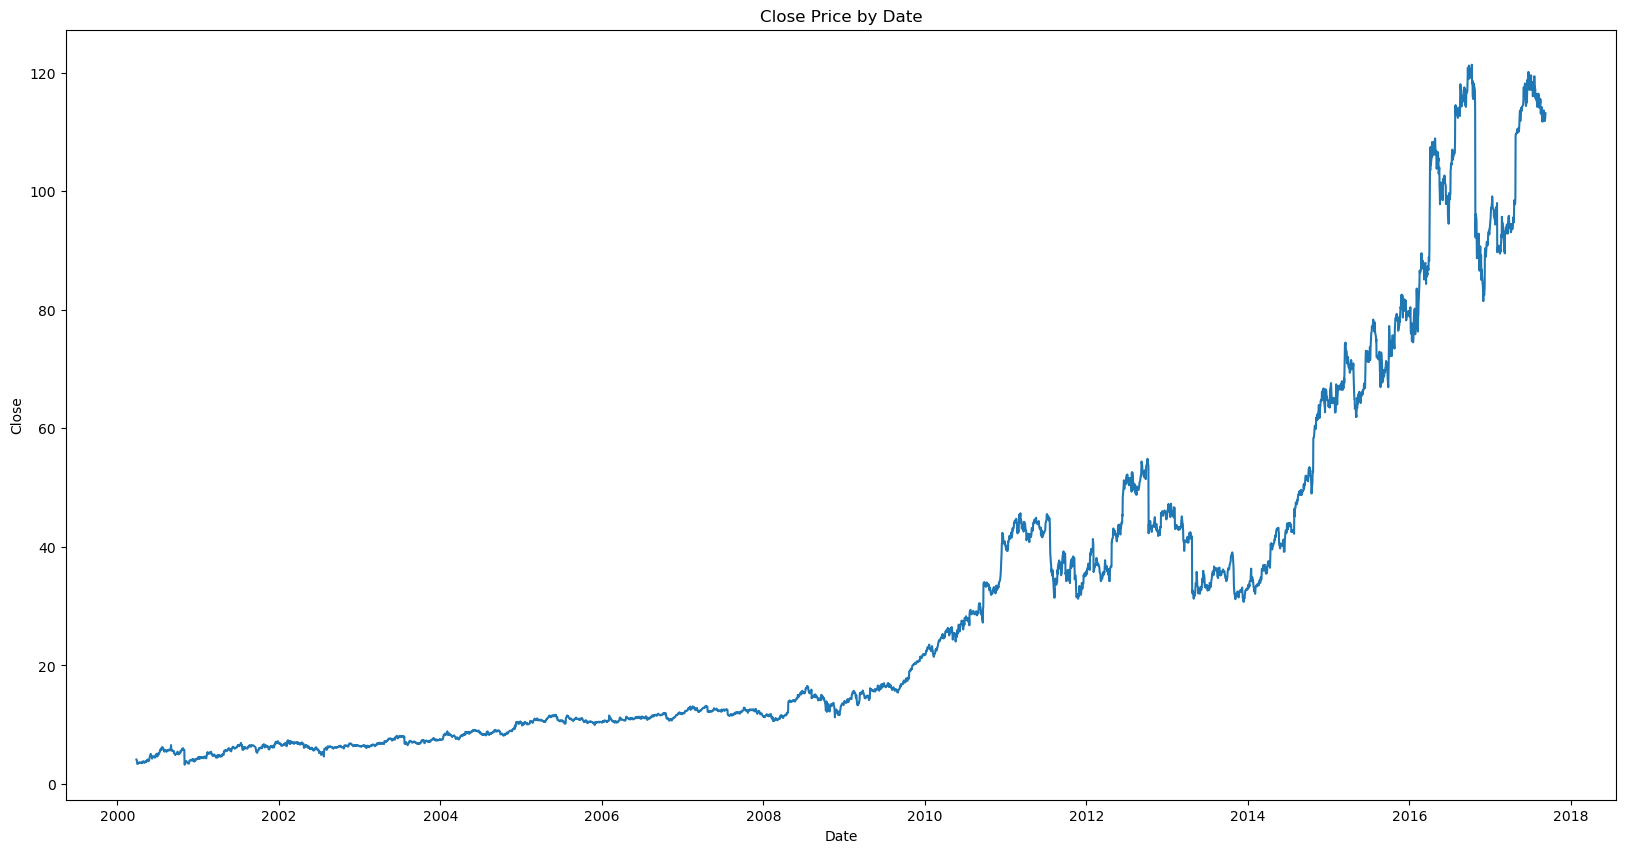

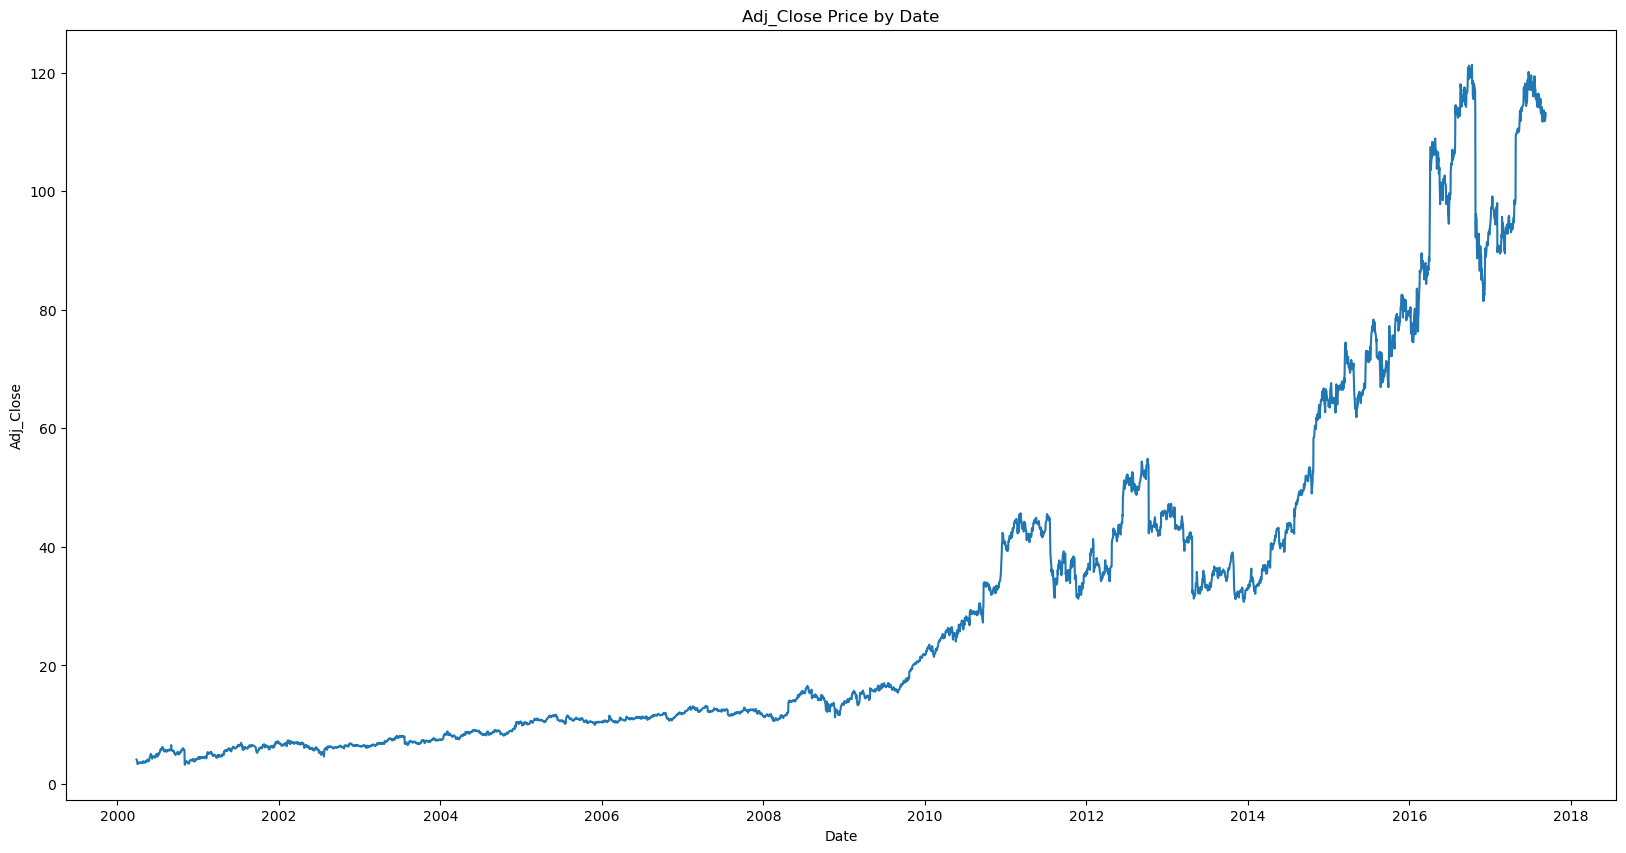

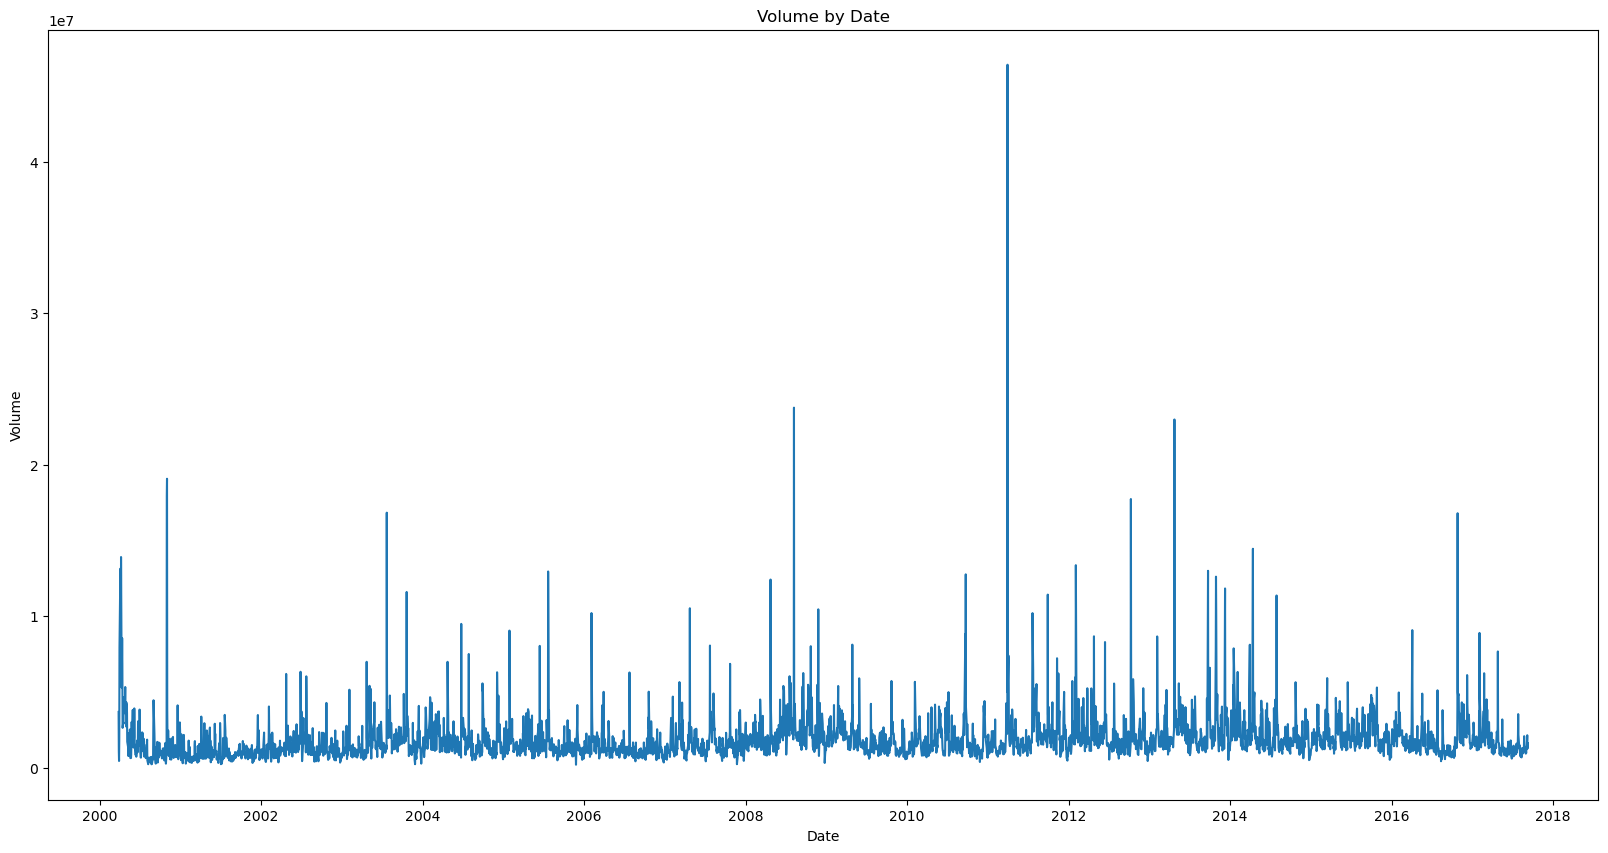

In [12]:
#plot close price
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='Date', y='Close')
plt.title('Close Price by Date')
plt.show()

#plot adjusted close price
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='Date', y='Adj_Close')
plt.title('Adj_Close Price by Date')
plt.show()

#plot volume
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='Date', y='Volume')
plt.title('Volume by Date')
plt.show()

## ARIMA Model for Time Series Regression

In [ ]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Sort the index to ensure the time series is in chronological order
df.sort_index(inplace=True)

# We create a new Series containing only the 'Adj_Close' price
ts_data = df['Adj_Close']

# Time series split must be sequential, not random! (e.g., 80% Train, 20% Test)
train_size = int(len(ts_data) * 0.8)

train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print("--- Data Split Summary ---")
print(f"Total Observations: {len(ts_data)}")
print(f"Training Set Size (80%): {len(train_data)} (from {train_data.index.min().date()} to {train_data.index.max().date()})")
print(f"Testing Set Size (20%): {len(test_data)} (from {test_data.index.min().date()} to {test_data.index.max().date()})")

--- Data Split Summary ---
Total Observations: 4392
Training Set Size (80%): 3513 (from 2000-03-27 to 2014-03-14)
Testing Set Size (20%): 879 (from 2014-03-17 to 2017-09-08)
--------------------------


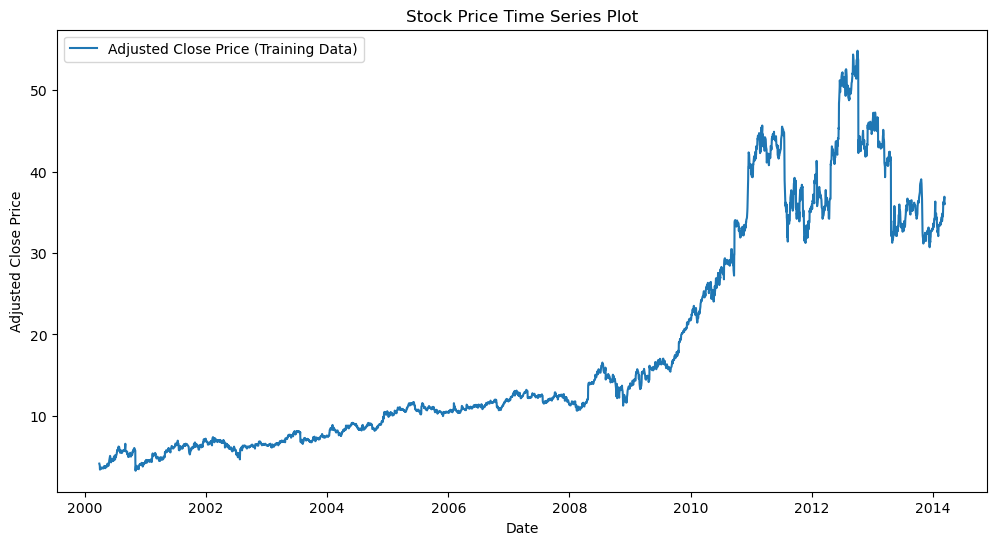

In [18]:
# --- 1. Visual Inspection ---
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Adjusted Close Price (Training Data)')
plt.title('Stock Price Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [21]:
def run_adf_test(timeseries):
    """
    Performs the ADF test and prints the results clearly.
    """
    # The adfuller function returns 5 values:
    # 0: ADF Statistic
    # 1: P-value
    # 2: Number of Lags Used
    # 3: Number of Observations Used
    # 4: Critical Values (1%, 5%, 10%)
    
    result = adfuller(timeseries, autolag='AIC')
    
    print('ADF Statistic: %f' % result[0])
    print('P-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    # Decision based on P-value
    print("\n--- ADF Test Result ---")
    if result[1] <= 0.05:
        print("P-value is <= 0.05. Reject the Null Hypothesis (H0). The series IS LIKELY STATIONARY.")
        return True # Stationary
    else:
        print("P-value is > 0.05. Fail to Reject the Null Hypothesis (H0). The series IS LIKELY NON-STATIONARY.")
        return False # Non-stationary

# Run the test on the original training data
print("--- Augmented Dickey-Fuller (ADF) Test ---")
is_stationary = run_adf_test(train_data)

--- Augmented Dickey-Fuller (ADF) Test ---
ADF Statistic: -0.699859
P-value: 0.846786
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

--- ADF Test Result ---
P-value is > 0.05. Fail to Reject the Null Hypothesis (H0). The series IS LIKELY NON-STATIONARY.


In [22]:
if not is_stationary:
    # Calculate the first difference
    train_data_diff = train_data.diff().dropna()
    
    print("\n--- Applying First Differencing (d=1) ---")
    print("New Differenced Series Head:")
    print(train_data_diff.head())
    
    # Run the ADF test on the differenced data
    print("\n--- Re-running ADF Test on Differenced Data ---")
    run_adf_test(train_data_diff)


--- Applying First Differencing (d=1) ---
New Differenced Series Head:
Date
2000-03-28   -0.109375
2000-03-29   -0.015625
2000-03-30   -0.156250
2000-03-31   -0.453125
2000-04-03    0.046875
Name: Adj_Close, dtype: float64

--- Re-running ADF Test on Differenced Data ---
ADF Statistic: -12.406986
P-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

--- ADF Test Result ---
P-value is <= 0.05. Reject the Null Hypothesis (H0). The series IS LIKELY STATIONARY.


In [27]:
#!pip install pmdarima
# import pmdarima as pm

# print("\n--- Alternative: Auto ARIMA for Optimal p and q Selection ---")

# # Auto ARIMA will automatically find the best (p, d, q) based on AIC
# # We fix d=1 based on our  previous step.
# # seasonal=False because stock prices generally don't have strong fixed annual seasonality.
# auto_model = pm.auto_arima(train_data,
#                            d=1,                # Fixed based on your ADF test result
#                            start_p=0, max_p=5,
#                            start_q=0, max_q=5,
#                            m=1,                # m=1 (non-seasonal)
#                            seasonal=False,
#                            stepwise=True,
#                            suppress_warnings=True,
#                            error_action='ignore')

# print("\nAuto ARIMA Results:")
# print(auto_model.summary())

# # The best order is the one that minimizes the AIC/BIC score
# best_p, best_d, best_q = auto_model.order
# print(f"\nOptimal ARIMA Order (p, d, q) determined by Auto ARIMA: ({best_p}, {best_d}, {best_q})")

--- Analyzing Autocorrelation of the Differenced Series ---


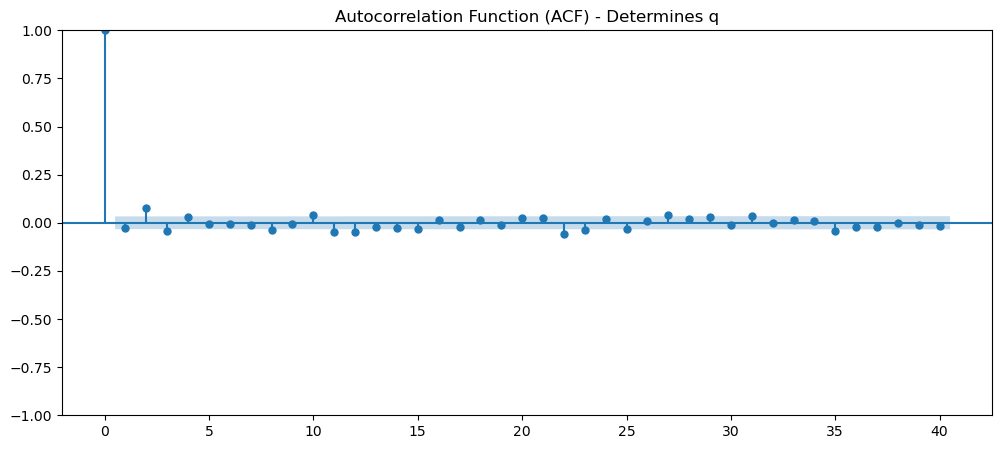

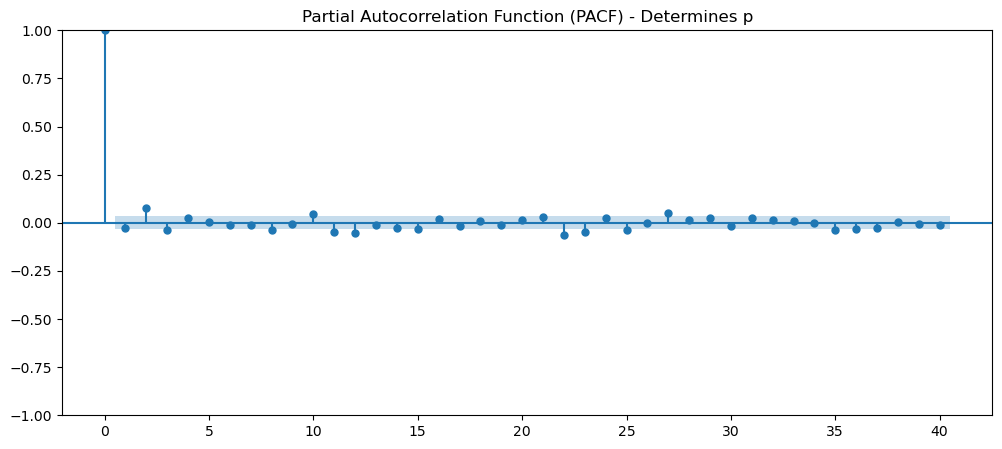

In [25]:
# we will have to perform 1st order diff for the training data
# also, we sill have to set d=1 for the ARIMA() model
train_data_diff = train_data.diff().dropna()

print("--- Analyzing Autocorrelation of the Differenced Series ---")
# the ACF plot helps determine the 'q' (Moving Average) order.
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train_data_diff, ax=ax, lags=40, title='Autocorrelation Function (ACF) - Determines q')
plt.show()

# the PACF plot helps determine the 'p' (Autoregressive) order.
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train_data_diff, ax=ax, lags=40, title='Partial Autocorrelation Function (PACF) - Determines p')
plt.show()

Interpretation Guidelines for p and q

The blue shaded area on the plots represents the 95% confidence interval. Any bar extending outside this area is statistically significant.

- p (AR Order) comes from the PACF Plot. it is the lag where the PACF plot cuts off (i.e., the last significant spike outside the blue zone).
- q (MA Order) comes from the ACF Plot. it is the lag where the ACF plot cuts off (i.e., the last significant spike outside the blue zone).

In [41]:
#interpreting the ACF and PACF plots, we should set:
p = 2
d = 1
q = 2
order = (p, d, q)

print(f"--- Fitting ARIMA{order} Model on Training Data ---")

# fit the ARIMA Model
try:
    # Note: we use the non-differenced training data (train_data), 
    # as the 'd' parameter handles differencing internally.
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()

    print(model_fit.summary())

except Exception as e:
    print(f"Error fitting model: {e}")
    print("If you encounter an error like 'non-invertible' or 'non-stationary', try slightly different (p, q) values.")
    print("-" * 50)
    exit()

--- Fitting ARIMA(2, 1, 2) Model on Training Data ---


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj_Close   No. Observations:                 3513
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2338.750
Date:                Mon, 08 Dec 2025   AIC                           4687.500
Time:                        18:38:08   BIC                           4718.320
Sample:                             0   HQIC                          4698.498
                               - 3513                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2186      0.038    -32.453      0.000      -1.292      -1.145
ar.L2         -0.8192      0.033    -24.929      0.000      -0.884      -0.755
ma.L1          1.2104      0.035     34.815      0.0

Key Finding: Since all P-values are 0.000 (well below the 0.05 threshold), all of the chosen parameters (p=2 and q=2) are statistically significant and essential to the model's structure.

The diagnostics check if the model's residuals (the errors or the difference between the actual and predicted values) behave like white noise, which is an assumption for a good model.

- Diagnostic Test	Value	P-value	Interpretation & Warning
- Ljung-Box (L1) (Q)	0.66	0.42	Good. Since P(Q)>0.05, there is no significant autocorrelation left in the residuals. This is the most important positive result for an ARIMA model!
- Jarque-Bera (JB)	3.1×106	0.00	Bad (but common). P(JB)<0.05 means the residuals are NOT normally distributed. This is typical for stock returns, which exhibit "fat tails" (extreme events happen more often than a normal distribution suggests).
- Heteroskedasticity (H)	23.25	0.00	Bad. P(H)<0.05 means the residuals suffer from Heteroskedasticity (the variance of the errors is not constant over time). For stock data, this is often called volatility clustering (big price movements are followed by big price movements).

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Square Error (RMSE) on Test Data: 50.8840


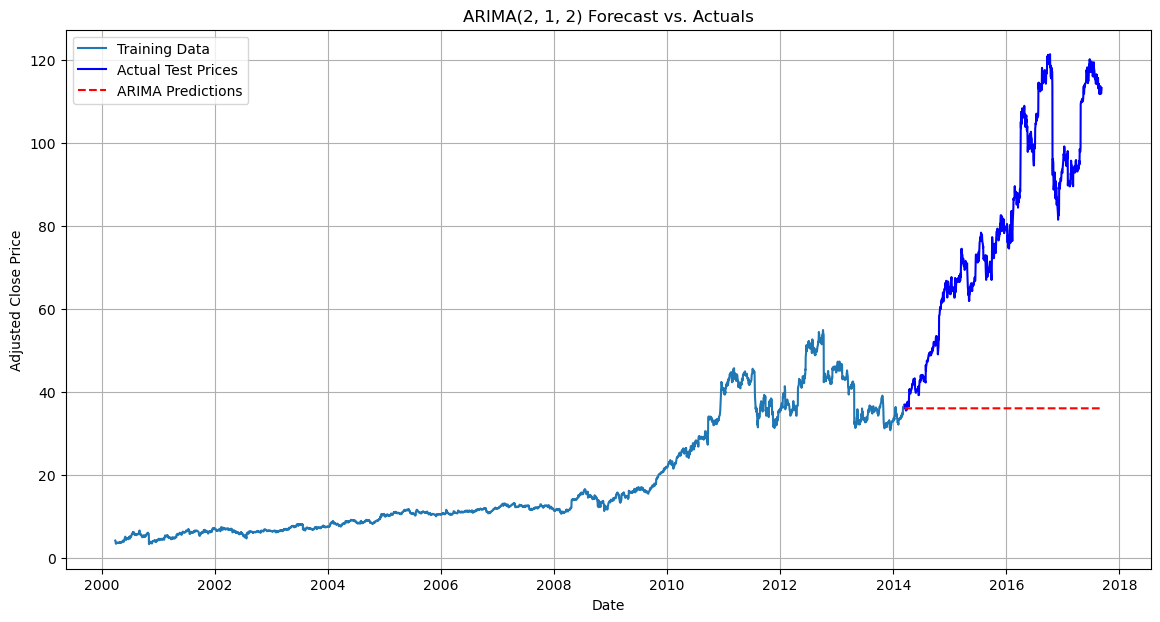

In [42]:
# generate predictions on the test set
start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions = model_fit.predict(start=start, end=end, dynamic=False)
predictions.index = test_data.index

# Create a DataFrame for easy comparison
forecast_df = pd.DataFrame({
    'Actual': test_data,
    'Predicted': predictions
})

# ealuate model performance
# we use Root Mean Square Error (RMSE) to measure the average magnitude of the errors
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"Root Mean Square Error (RMSE) on Test Data: {rmse:.4f}")

# visualize the Forecast vs. Actuals
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Prices', color='blue')
plt.plot(predictions, label='ARIMA Predictions', color='red', linestyle='--')
plt.title(f'ARIMA{order} Forecast vs. Actuals')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

It seems that the ARIMA model is good at fitting past data, but bad at predicting future data, as it outputs all constant values...

We will try other approaches

## GARCH Model

## Machine Learning - Regression

## Combined Approach